In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torchvision import transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
from torchvision.datasets import CIFAR10

In [5]:
train_transform = T.Compose([
    T.RandomCrop((32, 32), padding=4),
    T.RandomHorizontalFlip(0.5),
    T.ColorJitter(contrast=0.25),
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])
val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])

train_dataset = CIFAR10("./data/", download=True, train=True, transform=train_transform)
val_dataset = CIFAR10("./data/", download=True, train=False, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100)

In [7]:
from src.utils import set_random_seed

In [8]:
from src.utils import train, predict

In [9]:
from src.layers.ttrl import TTRL

class TTRLModel(nn.Module):
    def __init__(self):
        super(TTRLModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(3, 64, (3, 3), padding="same"),
                nn.BatchNorm2d(64),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, (3, 3), padding="same"),
                nn.BatchNorm2d(64),
                nn.ReLU(),
            ),
            nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1)),
            nn.Sequential(
                nn.Conv2d(64, 128, (3, 3), padding="same"),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, (3, 3), padding="same"),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            ),
            nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1)),
            nn.Sequential(
                nn.Conv2d(128, 128, (3, 3), padding="same"),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, (3, 3), padding="same"),
                nn.BatchNorm2d(128),
                nn.ReLU(),
            )
        )
        self.ttrl = TTRL(((16, 8), (8,), (8,)), ((8, 32), (2,), (2,)), (10,), (10,))
    
    def forward(self, tensor):
        tensor = self.conv(tensor)
        tensor = torch.reshape(tensor, (tensor.shape[0], 16, 8, 8, 8))
        return self.ttrl(tensor)


set_random_seed(12347)
model = TTRLModel()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss(reduction="mean")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.1, verbose=True)
# scheduler = None
n_epochs = 100

device = "cuda:0" if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
# device = "cpu"

Adjusting learning rate of group 0 to 1.0000e-02.


In [10]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels.to("cpu"), true_labels.to("cpu"))
print("tests passed")

tests passed


In [11]:
accuracies = train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, plot=False)

  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 0, Train loss: 1.5779019438028337, Validation loss: 1.2125861644744873, Validation accuracy: 0.5846


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 1, Train loss: 0.8950261431932449, Validation loss: 0.8831769227981567, Validation accuracy: 0.6986


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 2, Train loss: 0.7224382990598679, Validation loss: 0.6969789266586304, Validation accuracy: 0.7667


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 3, Train loss: 0.6292630370259285, Validation loss: 0.6380563378334045, Validation accuracy: 0.7825


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 4, Train loss: 0.5657939979434013, Validation loss: 0.7439260482788086, Validation accuracy: 0.7745


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 5, Train loss: 0.5126030248403549, Validation loss: 0.6345679759979248, Validation accuracy: 0.7894


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 6, Train loss: 0.4709197933673859, Validation loss: 0.6971984505653381, Validation accuracy: 0.7852


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 7, Train loss: 0.43722208121418954, Validation loss: 0.5346994996070862, Validation accuracy: 0.8169


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 8, Train loss: 0.40810433411598207, Validation loss: 0.6369922757148743, Validation accuracy: 0.8024


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 9, Train loss: 0.3872393309772015, Validation loss: 0.5609076023101807, Validation accuracy: 0.8195


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 10, Train loss: 0.363744919270277, Validation loss: 0.5414921045303345, Validation accuracy: 0.8252


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 11, Train loss: 0.343386435598135, Validation loss: 0.5616918802261353, Validation accuracy: 0.8292


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 12, Train loss: 0.32362713661789894, Validation loss: 0.551571249961853, Validation accuracy: 0.8332


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 13, Train loss: 0.31076316273212434, Validation loss: 0.5517103672027588, Validation accuracy: 0.8375


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 14, Train loss: 0.29291734866797925, Validation loss: 0.4925519526004791, Validation accuracy: 0.8546


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 15, Train loss: 0.2791294307112694, Validation loss: 0.5050559043884277, Validation accuracy: 0.8451


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 16, Train loss: 0.2704182453751564, Validation loss: 0.4523705840110779, Validation accuracy: 0.8668


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 17, Train loss: 0.2542887548953295, Validation loss: 0.44317659735679626, Validation accuracy: 0.8646


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 18, Train loss: 0.24340671749413015, Validation loss: 0.5293048620223999, Validation accuracy: 0.8526


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 19, Train loss: 0.23372819587588312, Validation loss: 0.48029330372810364, Validation accuracy: 0.863


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 20, Train loss: 0.22080902916193007, Validation loss: 0.42524442076683044, Validation accuracy: 0.8768


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 21, Train loss: 0.2102682906612754, Validation loss: 0.5077688097953796, Validation accuracy: 0.8621


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 22, Train loss: 0.20617625284194946, Validation loss: 0.41302767395973206, Validation accuracy: 0.8766


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 23, Train loss: 0.19483678202331067, Validation loss: 0.5007784962654114, Validation accuracy: 0.8662


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 24, Train loss: 0.18682267327606678, Validation loss: 0.4182263910770416, Validation accuracy: 0.8773


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 25, Train loss: 0.17954726109653713, Validation loss: 0.4225586950778961, Validation accuracy: 0.8799


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 26, Train loss: 0.17183962263911962, Validation loss: 0.43038129806518555, Validation accuracy: 0.8821


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 27, Train loss: 0.16980081290006638, Validation loss: 0.4076787531375885, Validation accuracy: 0.8838


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch: 28, Train loss: 0.1625400502830744, Validation loss: 0.47501543164253235, Validation accuracy: 0.8764


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 29, Train loss: 0.15896333105489613, Validation loss: 0.4732537567615509, Validation accuracy: 0.8748


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 30, Train loss: 0.0975421346500516, Validation loss: 0.3980107307434082, Validation accuracy: 0.9019


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 31, Train loss: 0.07992853372171521, Validation loss: 0.4133383333683014, Validation accuracy: 0.9041


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 32, Train loss: 0.07348007728159428, Validation loss: 0.43085530400276184, Validation accuracy: 0.9041


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 33, Train loss: 0.06746968194935471, Validation loss: 0.43277987837791443, Validation accuracy: 0.9043


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 34, Train loss: 0.06245985063537955, Validation loss: 0.4508613049983978, Validation accuracy: 0.9041


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 35, Train loss: 0.06290303931757808, Validation loss: 0.4469839632511139, Validation accuracy: 0.9042


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 36, Train loss: 0.05744428590685129, Validation loss: 0.4616515636444092, Validation accuracy: 0.9044


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 37, Train loss: 0.05693874805700034, Validation loss: 0.4663999378681183, Validation accuracy: 0.9075


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 38, Train loss: 0.05526496552489698, Validation loss: 0.4851219952106476, Validation accuracy: 0.9046


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 39, Train loss: 0.05265119200199842, Validation loss: 0.4812488257884979, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 40, Train loss: 0.05050796013418585, Validation loss: 0.5016607642173767, Validation accuracy: 0.9032


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 41, Train loss: 0.049816333538852633, Validation loss: 0.4962407052516937, Validation accuracy: 0.9057


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 42, Train loss: 0.04999292505253106, Validation loss: 0.5105234384536743, Validation accuracy: 0.906


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 43, Train loss: 0.04601716569112614, Validation loss: 0.5223199129104614, Validation accuracy: 0.9045


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 44, Train loss: 0.04725342270755209, Validation loss: 0.5257389545440674, Validation accuracy: 0.9023


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 45, Train loss: 0.04424900551442988, Validation loss: 0.5316106081008911, Validation accuracy: 0.9041


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 46, Train loss: 0.04500738539872691, Validation loss: 0.5282843112945557, Validation accuracy: 0.9062


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 47, Train loss: 0.0418517064449843, Validation loss: 0.5452989339828491, Validation accuracy: 0.9045


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 48, Train loss: 0.0426125244605355, Validation loss: 0.542610228061676, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 49, Train loss: 0.040876397079555316, Validation loss: 0.5450383424758911, Validation accuracy: 0.9031


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 50, Train loss: 0.03920739833510015, Validation loss: 0.5708152651786804, Validation accuracy: 0.9019


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 51, Train loss: 0.03833122891397216, Validation loss: 0.5748798847198486, Validation accuracy: 0.9046


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 52, Train loss: 0.03676149744563736, Validation loss: 0.5754191875457764, Validation accuracy: 0.9033


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 53, Train loss: 0.03864580461499281, Validation loss: 0.5738648772239685, Validation accuracy: 0.9025


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 54, Train loss: 0.03693339279806242, Validation loss: 0.5690422058105469, Validation accuracy: 0.9058


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 55, Train loss: 0.036612498447299004, Validation loss: 0.577621340751648, Validation accuracy: 0.9043


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 56, Train loss: 0.03597980370232835, Validation loss: 0.5804980397224426, Validation accuracy: 0.9043


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 57, Train loss: 0.03540586024988443, Validation loss: 0.5915612578392029, Validation accuracy: 0.9023


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 58, Train loss: 0.032816929078660906, Validation loss: 0.6023487448692322, Validation accuracy: 0.9042


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 59, Train loss: 0.03180849531141575, Validation loss: 0.6107864379882812, Validation accuracy: 0.9041


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 60, Train loss: 0.030412985797738656, Validation loss: 0.6049435138702393, Validation accuracy: 0.9035


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 61, Train loss: 0.02732580592832528, Validation loss: 0.5956910252571106, Validation accuracy: 0.9049


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 62, Train loss: 0.02941798020922579, Validation loss: 0.6004730463027954, Validation accuracy: 0.9042


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 63, Train loss: 0.027997836663620546, Validation loss: 0.5985324382781982, Validation accuracy: 0.9041


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 64, Train loss: 0.027623385065700858, Validation loss: 0.6046658754348755, Validation accuracy: 0.9034


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 65, Train loss: 0.025143337122164666, Validation loss: 0.603848397731781, Validation accuracy: 0.9042


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 66, Train loss: 0.026669952409458346, Validation loss: 0.6057349443435669, Validation accuracy: 0.9048


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 67, Train loss: 0.02678424149006605, Validation loss: 0.6039718389511108, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 68, Train loss: 0.026330676142824815, Validation loss: 0.6032112240791321, Validation accuracy: 0.9051


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 69, Train loss: 0.025811579630710183, Validation loss: 0.6046731472015381, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 70, Train loss: 0.02579838905436918, Validation loss: 0.6079170107841492, Validation accuracy: 0.9058


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 71, Train loss: 0.025933914713561535, Validation loss: 0.6068958044052124, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 72, Train loss: 0.024887401687679812, Validation loss: 0.6083212494850159, Validation accuracy: 0.9061


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 73, Train loss: 0.024503745272522793, Validation loss: 0.6079024076461792, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 74, Train loss: 0.025638795485021546, Validation loss: 0.6118194460868835, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 75, Train loss: 0.024947847096831538, Validation loss: 0.611517608165741, Validation accuracy: 0.905


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 76, Train loss: 0.02407811093633063, Validation loss: 0.6123551726341248, Validation accuracy: 0.9046


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 77, Train loss: 0.0253999897724716, Validation loss: 0.6141132712364197, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 78, Train loss: 0.025582548357080667, Validation loss: 0.6122925877571106, Validation accuracy: 0.9063


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 79, Train loss: 0.02434228686336428, Validation loss: 0.6156109571456909, Validation accuracy: 0.9046


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 80, Train loss: 0.02435207158070989, Validation loss: 0.6137056946754456, Validation accuracy: 0.9058


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 81, Train loss: 0.024112251903163268, Validation loss: 0.6205459237098694, Validation accuracy: 0.9056


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 82, Train loss: 0.02471683786693029, Validation loss: 0.6184136271476746, Validation accuracy: 0.9057


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 83, Train loss: 0.022806531195295975, Validation loss: 0.6223087906837463, Validation accuracy: 0.9055


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 84, Train loss: 0.023502607690752485, Validation loss: 0.628065824508667, Validation accuracy: 0.904


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 85, Train loss: 0.024770538385491817, Validation loss: 0.6298100352287292, Validation accuracy: 0.9044


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 86, Train loss: 0.02272666959220078, Validation loss: 0.6229904890060425, Validation accuracy: 0.9049


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 87, Train loss: 0.025026361347874625, Validation loss: 0.629223108291626, Validation accuracy: 0.9054


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 88, Train loss: 0.022456870852038263, Validation loss: 0.6262326240539551, Validation accuracy: 0.9045


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 89, Train loss: 0.022846664906013756, Validation loss: 0.6363304257392883, Validation accuracy: 0.9039


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 90, Train loss: 0.024577595938113518, Validation loss: 0.6353151202201843, Validation accuracy: 0.905


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 91, Train loss: 0.023125650038942694, Validation loss: 0.6301485896110535, Validation accuracy: 0.9058


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 92, Train loss: 0.024116634122503457, Validation loss: 0.6319446563720703, Validation accuracy: 0.9054


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 93, Train loss: 0.02402754505595658, Validation loss: 0.6349958181381226, Validation accuracy: 0.905


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 94, Train loss: 0.022669694029609673, Validation loss: 0.6324781775474548, Validation accuracy: 0.9049


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 95, Train loss: 0.023008865629439244, Validation loss: 0.6293615102767944, Validation accuracy: 0.9057


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 96, Train loss: 0.022575040423485918, Validation loss: 0.6315243244171143, Validation accuracy: 0.9053


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 97, Train loss: 0.021851589048164897, Validation loss: 0.634719967842102, Validation accuracy: 0.9052


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 98, Train loss: 0.022134485729853624, Validation loss: 0.6306842565536499, Validation accuracy: 0.9047


  0%|          | 0/500 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 99, Train loss: 0.023264695941470563, Validation loss: 0.6303688883781433, Validation accuracy: 0.9058


Accuracy: 0.9058


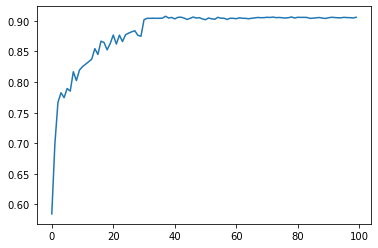

In [12]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels.to("cpu"), predicted_labels.to("cpu"))
print(f"Accuracy: {accuracy}")
plt.plot(accuracies)
plt.show()

In [13]:
torch.save({
    "model": model.state_dict(),
}, "./models/conv-trl-6.5-state-dict.pt")

In [10]:
# checkpoint = torch.load("./models/conv-trl-3-state-dict.pt")
# model.load_state_dict(checkpoint["model"])

<All keys matched successfully>